<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

# Abstract

This project implements a parallelised community detection algorithm proposed by [*"S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)"*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. We use Python, Spark and AWS as the environment.

# 1. Introduction

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. We focus our work on community detection...
The paper we base ourself on is named " Parallel community detection on large graphs with MapReduce and GraphChi" published in 2015 by Seunghyeon Moon, Jae-Gil Lee, Minseo Kang, Minsoo Choy and Jin-woo Lee. This paper is based on "Community structure in social and biological networks" in 2001 by Michelle Girvan, M. E. J. Newman.
Our work is covering the Shortest-Path Betweeness MapReduce Algorithm (SPB-MRA) and the parallel calculation using pyspark on AWS.

# 2. Model

Community Detection, Modularity Method

# 3. Algorithm

Girvan-Newman Algorithm

<img src="img/algo.png" width="400" align="left">

# 4. Data

Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)

# 5. Environment

Python + Spark + AWS

# 6. Implementation

Here is the code:

In [1]:
import numpy as np
import pandas as pd

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

In [4]:
# Read the data
#data = np.loadtxt("./Data/ca-GrQc_small.txt", dtype='uint16')
data = np.loadtxt("./Data/test2.txt", dtype='uint16')
print(data)
print(type(data))
#data = pd.DataFrame(data)
#data.to_csv("./Data/test_with_index.txt", sep="\t", header=None, index=False)

[[1 2]
 [1 3]
 [2 3]
 [4 3]
 [3 5]
 [5 6]
 [5 7]]
<class 'numpy.ndarray'>


In [5]:
# Make a list of adjacency lists (first element is the node of origin)
nodeId = np.unique(data)
nrow = len(data)
adj_list = []

for n in nodeId:
    adj = []
    for i in range(nrow):
        if data[i, 0] == n:
            adj.append(data[i, 1])
        if data[i, 1] == n:
            adj.append(data[i, 0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
#print(adj_list)

In [6]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
#for i in range(len(network)):
#    print(network[i])

# Parallelisation part

In [8]:
#sc.stop()
#import findspark 
#findspark.init()
from pyspark import SparkContext, SparkConf
#import copy in order to do deepcopy of tuples
from copy import deepcopy #For a deep copy of tuple
#from operator import itemgetter
from itertools import groupby
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [9]:
# Set a dataset and create key-value pairs
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

# < Stage 1 - Map >

In [10]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result
'''
pos_map1 = rdd.flatMap(stage1_map)
pos_map1.collect()
'''
# Add artifitial records in order to test MapReduce functions
#for_testing = pos_map1.collect()
#add_for_testing = [(4, [4, 2, 'a', 1, [2], []]), 
#    (4, [2, 1, 'a', 1, [3], [1, 3]]),
#    (4, [2, 2, 'a', 1, [2], []]),
#    (4, [2, 5, 'a', 1, [2], []]),
#    (4, [2, 1, 'a', 1, [3], [1, 3]]),
#    (4, [2, 1, 'a', 1, [5], [5]]),
#    (4, [2, 1, 'a', 1, [2], [2]])]
#for_testing.extend(add_for_testing)
#
#for i in range(len(for_testing)):
#    print(for_testing[i])
#pos_map1_test = sc.parallelize(for_testing)

'\npos_map1 = rdd.flatMap(stage1_map)\npos_map1.collect()\n'

# < Stage 1 - Reduce >

This part consists of 5 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples

In [11]:
#pos_map1.collect()
#pos_map1_test.collect()
'''
red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
'''
#red1_twokeys = pos_map1_test.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
#red1_twokeys.collect()

'\nred1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))\n'

In [12]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)
'''
red1_grouped = red1_twokeys.reduceByKey(join)
#red1_twokeys.reduceByKey(join).collect()
'''

'\nred1_grouped = red1_twokeys.reduceByKey(join)\n#red1_twokeys.reduceByKey(join).collect()\n'

In [13]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x
'''
red1_weighted = red1_grouped.map(stage1_reduce)
#red1_grouped.map(stage1_reduce).collect()
'''

'\nred1_weighted = red1_grouped.map(stage1_reduce)\n#red1_grouped.map(stage1_reduce).collect()\n'

In [14]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v
'''
# From two-keys tuples to one-key tuples
record = red1_weighted.map(twokeys_to_onekey).collect()

# To flatten the grouped values (non-parallelized)
new = []
for i in range(len(record)):
    if type(record[i][1][1]) is list:
        record[i]
        key = record[i][0]
        srcId = [record[i][1][0]]
        others = record[i][1][1:]
        for j in range(len(others)):
            s = srcId.copy()
            o = others[j]
            s.extend(o)
            newrec = (key, s)
            new.append(newrec)
pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  
pos_red1.extend(new)
for i in range(len(pos_red1)):
    print(pos_red1[i])
output = pos_red1.copy()
'''

'\n# From two-keys tuples to one-key tuples\nrecord = red1_weighted.map(twokeys_to_onekey).collect()\n\n# To flatten the grouped values (non-parallelized)\nnew = []\nfor i in range(len(record)):\n    if type(record[i][1][1]) is list:\n        record[i]\n        key = record[i][0]\n        srcId = [record[i][1][0]]\n        others = record[i][1][1:]\n        for j in range(len(others)):\n            s = srcId.copy()\n            o = others[j]\n            s.extend(o)\n            newrec = (key, s)\n            new.append(newrec)\npos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  \npos_red1.extend(new)\nfor i in range(len(pos_red1)):\n    print(pos_red1[i])\noutput = pos_red1.copy()\n'

In [15]:
# Iteration until status becomes 'i' for all tuples
act_counter = 1
ite = 1
while act_counter > 0:
    rdd = sc.parallelize(output)
# <stage1 map>
    pos_map1 = rdd.flatMap(stage1_map)
#    test_only = pos_map1.collect()
#    print("After Map of iteration", ite, ":")
#    for i in range(len(test_only)):
#        print(test_only[i])
# <stage1 reduce>
    red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
    red1_grouped = red1_twokeys.reduceByKey(join)
    red1_weighted = red1_grouped.map(stage1_reduce)
    record = red1_weighted.map(twokeys_to_onekey).collect()
    new = []
    for i in range(len(record)):
        if type(record[i][1][1]) is list:
            record[i]
            key = record[i][0]
            srcId = [record[i][1][0]]
            others = record[i][1][1:]
            for j in range(len(others)):
                s = srcId.copy()
                o = others[j]
                s.extend(o)
                newrec = (key, s)
                new.append(newrec)
    pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  
    pos_red1.extend(new)
    output = pos_red1.copy()
# Fill in adjList before going to next iteration
    for i in range(len(output)):
        if output[i][1][5] == []:
            for j in range(len(adj_list)):
                if adj_list[j][0] == output[i][0]:
                    output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                    break
#    test_only = output
#    print("After Reduce of iteration", ite, ":")
#    for i in range(len(test_only)):
#        print(test_only[i])
    act_counter = 0
    for i in range(len(output)):
        if output[i][1][2] == 'a':
            act_counter += 1
    ite += 1
#    print("act_counter = ", act_counter)
stage1_output = output.copy()
print("Iteration has been finished. Stage1 was iterated for", ite-1, "times.")
print("Stage1 result is:")
for i in range(len(stage1_output)):
    print(stage1_output[i])

act_counter =  14
act_counter =  22
act_counter =  20
act_counter =  8
act_counter =  0
Iteration has been finished. Stage1 was iterated for 5 times.
Stage1 result is:
(7, [3, 3, 'i', 1, [3, 5, 7], [5]])
(6, [4, 4, 'i', 1, [4, 3, 5, 6], [5]])
(4, [6, 4, 'i', 1, [6, 5, 3, 4], [3]])
(5, [5, 1, 'i', 1, [5], [3, 6, 7]])
(7, [7, 1, 'i', 1, [7], [5]])
(1, [1, 1, 'i', 1, [1], [2, 3]])
(3, [3, 1, 'i', 1, [3], [1, 2, 4, 5]])
(2, [4, 3, 'i', 1, [4, 3, 2], [1, 3]])
(1, [5, 3, 'i', 1, [5, 3, 1], [2, 3]])
(4, [2, 3, 'i', 1, [2, 3, 4], [3]])
(6, [3, 3, 'i', 1, [3, 5, 6], [5]])
(4, [5, 3, 'i', 1, [5, 3, 4], [3]])
(6, [7, 3, 'i', 1, [7, 5, 6], [5]])
(7, [4, 4, 'i', 1, [4, 3, 5, 7], [5]])
(5, [6, 2, 'i', 1, [6, 5], [3, 6, 7]])
(1, [2, 2, 'i', 1, [2, 1], [2, 3]])
(2, [3, 2, 'i', 1, [3, 2], [1, 3]])
(3, [4, 2, 'i', 1, [4, 3], [1, 2, 4, 5]])
(4, [1, 3, 'i', 1, [1, 3, 4], [3]])
(7, [5, 2, 'i', 1, [5, 7], [5]])
(4, [4, 1, 'i', 1, [4], [3]])
(6, [6, 1, 'i', 1, [6], [5]])
(5, [3, 2, 'i', 1, [3, 5], [3, 6, 7]]

# < Stage2 - Map >

In [105]:
pre_map2 = sc.parallelize(stage1_output)

def stage2_map(x):
    for i in range(len(x[1][4]))
    return

pos_map2 = pre_map1.map(stage2_map)
pos_map2.collect()

# Visualisation Part

In [ ]:
# ------- UNDIRECTED
# Build a dataframe with your connections
# This time a pair can appear 2 times, in one side or in the other!
df = pd.DataFrame({ 'from':['D', 'A', 'B', 'C','A'], 'to':['A', 'D', 'A', 'E','C']})
df
# Build your graph. Note that we use the Graph function to create the graph!
G=nx.from_pandas_dataframe(df, 'from', 'to', create_using=nx.Graph() )

# Make the graphnx.draw(G, with_labels=True, node_size=1500, alpha=0.3, arrows=True)
plt.title("UN-Directed")

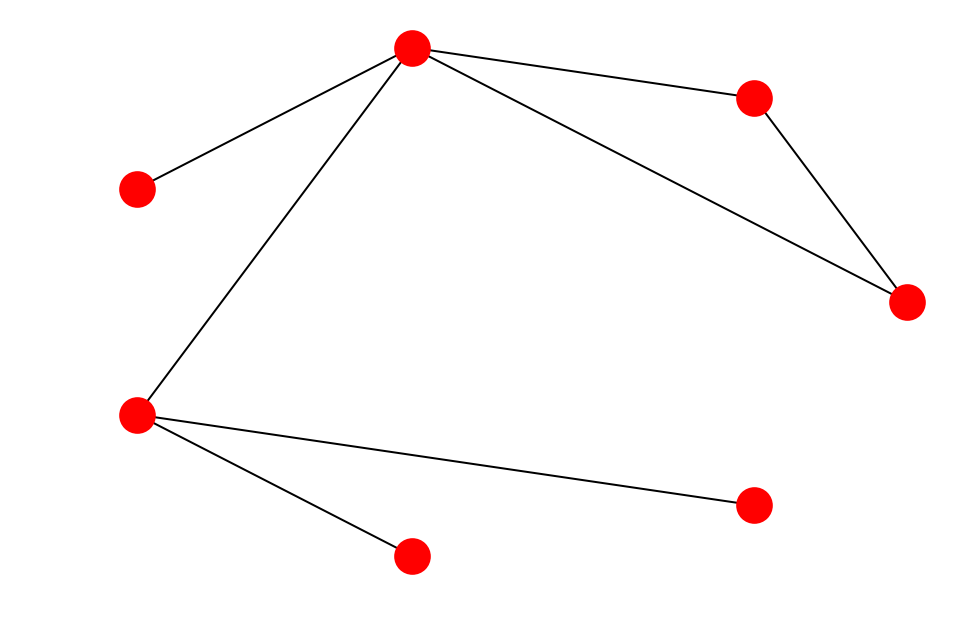

In [100]:
#Visualisation of the graph
#This is just for reference for now
import pandas
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    # show graph
    plt.show()
    
draw_graph(data)


ANNEX: Spark SQL - Tried Spark DataFrame but did not use it in the end

In [286]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('ELTDM').getOrCreate()
from pyspark.sql import functions as func
from pyspark.sql.functions import count, col
from pyspark.sql.window import Window
from pyspark.sql.functions import struct

from pyspark.sql.types import StructField
from pyspark.sql.types import StructType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType

In [316]:
fields = [
    StructField('targetId', IntegerType(), False),
    StructField('sourceId', IntegerType(), False),
    StructField('distance', IntegerType(), False),
    StructField('status', StringType(), False), 
    StructField('weight', IntegerType(), False),
    StructField('pathInfo', ArrayType(IntegerType(), True), False), 
    StructField('adjList', ArrayType(IntegerType(), True), False)]
schema = StructType(fields)

temp1 = pos_map1_test.map(lambda x: (int(x[0]),int(x[1][0]),int(x[1][1]),str(x[1][2]),int(x[1][3]),[int(s) for s in x[1][4]],[int(s) for s in x[1][5]])).collect()
temp2 = sc.parallelize(temp1)
df = spark.createDataFrame(temp2, schema)
df.show(100)

print(df.printSchema())
df.registerTempTable("Stage1_pre_reduce")

+--------+--------+--------+------+------+--------+------------+
|targetId|sourceId|distance|status|weight|pathInfo|     adjList|
+--------+--------+--------+------+------+--------+------------+
|       1|       1|       1|     i|     1|     [1]|[8, 2, 3, 4]|
|       8|       1|       1|     a|     1|     [1]|          []|
|       2|       1|       1|     a|     1|     [1]|          []|
|       3|       1|       1|     a|     1|     [1]|          []|
|       4|       1|       1|     a|     1|     [1]|          []|
|       2|       2|       1|     i|     1|     [2]|   [1, 4, 5]|
|       1|       2|       1|     a|     1|     [2]|          []|
|       4|       2|       1|     a|     1|     [2]|          []|
|       5|       2|       1|     a|     1|     [2]|          []|
|       3|       3|       1|     i|     1|     [3]|   [1, 4, 5]|
|       1|       3|       1|     a|     1|     [3]|          []|
|       4|       3|       1|     a|     1|     [3]|          []|
|       5|       3|      

In [381]:
q = """
SELECT
  targetId,
  sourceId,
  distance,
  status,
  weight,
  pathInfo,
  adjList
FROM
  Stage1_pre_reduce
ORDER BY targetId, sourceId
"""
df_ = sqlContext.sql(q)
df_.registerTempTable("Sorted")
df_.show()

+--------+--------+--------+------+------+--------+------------+
|targetId|sourceId|distance|status|weight|pathInfo|     adjList|
+--------+--------+--------+------+------+--------+------------+
|       1|       1|       1|     i|     1|     [1]|[8, 2, 3, 4]|
|       1|       2|       1|     a|     1|     [2]|          []|
|       1|       3|       1|     a|     1|     [3]|          []|
|       1|       4|       1|     a|     1|     [4]|          []|
|       1|       8|       1|     a|     1|     [8]|          []|
|       2|       1|       1|     a|     1|     [1]|          []|
|       2|       2|       1|     i|     1|     [2]|   [1, 4, 5]|
|       2|       4|       1|     a|     1|     [4]|          []|
|       2|       5|       1|     a|     1|     [5]|          []|
|       3|       1|       1|     a|     1|     [1]|          []|
|       3|       3|       1|     i|     1|     [3]|   [1, 4, 5]|
|       3|       4|       1|     a|     1|     [4]|          []|
|       3|       5|      

In [ ]:
q = """
SELECT
  targetId,
  sourceId,
  distance,
  MIN(distance) OVER (PARTITION BY sourceId ORDER BY targetId) as min_distance,
  status,
  weight,
  pathInfo,
  adjList
FROM
  Stage1_pre_reduce
"""
sqlContext.sql(q).show(100)

# 7. Result and discussion

bla bla bla

# 8.Efficiency

We can compare above result with that of non-parallelized algorithm.